2024-11-22

# XKCD dnd dice problem

In [21]:
from functools import cache, lru_cache

import numpy as np
from numpy import log

from time import time

import matplotlib.pyplot as plt

In [6]:
def prod(l):
    if not l:
        return 1
    return l[0] * prod(l[1:])

In [7]:
def multisets(n, k):
    mset = (0,) * k
    msets = [mset]
    while mset != (n-1,) * k:
        last = mset[-1]
        lasts = [i for i in range(k) if mset[i] == last]
        j = lasts[0]
        mset = mset[:j] + (last+1,) + (0,) * (k-j-1)
        msets.append(mset)
    return msets

In [8]:
@cache
def multisets_prod(maxprod, diceset):
    if maxprod < 1:
        return []
    if not diceset:
        return [()]
    msets = []
    big, rest = diceset[-1], diceset[:-1]
    maxbig = int(log(maxprod) / log(big))
    for nbig in range(maxbig + 1):
        restmaxprod = maxprod // (big**nbig)
        mset_big = (len(diceset)-1,) * nbig
        rest_msets = multisets_prod(restmaxprod, rest)
        new_msets = [mset+mset_big for mset in rest_msets]
        msets += new_msets
    return msets

In [22]:
@lru_cache(20_000_000)
def sum_num(n, dice):
    if n > sum(dice) or n < len(dice):
        return 0
    if not dice:
        return int(n == 0)
    if len(dice) == 1:
        return 1
    first, rest = dice[0], dice[1:]
    tot = 0
    for i in range(1, first+1):
        tot += sum_num(n-i, rest)
    return tot

In [10]:
PRIMES = [2]

@cache
def primes_below(n):
    global PRIMES
    if PRIMES[-1] >= n-1:
        return [p for p in PRIMES if p<n]
    PRIMES += [k for k in range(PRIMES[-1]+1, n) if is_prime(k)]
    return PRIMES

@cache
def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    for p in all_primes():
        if p*p > n:
            return True
        if n%p == 0:
            return False
            
def all_primes():
    for p in PRIMES:
        yield p
    k = p + 1
    while True:
        if is_prime(k):
            PRIMES.append(k)
            yield k
        k += 1

In [11]:
@cache
def prime_factors(n):
    if not n:
        raise ValueError(n)
    if n == 1:
        return ()
    if is_prime(n):
        return (n,)
    for p in all_primes():
        if n % p == 0:
            return (p,) + prime_factors(n//p)

In [12]:
def gcd(m, n):
    m, n = max(m, n), min(m, n)
    if not n:
        return m
    return gcd(n, m-n)

In [13]:
for f in multisets_prod, sum_num, primes_below, is_prime, prime_factors:
    f.cache_clear()

In [23]:
for f in multisets_prod, sum_num, primes_below, is_prime, prime_factors:
    print(f.cache_info())

CacheInfo(hits=0, misses=0, maxsize=None, currsize=0)
CacheInfo(hits=0, misses=0, maxsize=20000000, currsize=0)
CacheInfo(hits=0, misses=0, maxsize=None, currsize=0)
CacheInfo(hits=135, misses=17736, maxsize=None, currsize=17736)
CacheInfo(hits=19323, misses=17737, maxsize=None, currsize=17737)


In [19]:
for f in multisets_prod, sum_num, primes_below, is_prime, prime_factors:
    print(f.cache_info())

CacheInfo(hits=0, misses=0, maxsize=None, currsize=0)
CacheInfo(hits=63047605, misses=52020114, maxsize=None, currsize=52020113)
CacheInfo(hits=0, misses=0, maxsize=None, currsize=0)
CacheInfo(hits=135, misses=17736, maxsize=None, currsize=17736)
CacheInfo(hits=19323, misses=17737, maxsize=None, currsize=17737)


In [14]:
DICE = [4, 6, 8, 10, 12, 20]

In [32]:
def find_dice(nom, den, max_dice):
    found = False
    for k in range(max_dice+1):
        for mset in multisets(len(DICE), k):
            dice = tuple(DICE[i] for i in mset)
            poss = prod(dice)
            if poss % den:
                continue
            tot = 0
            target = sum(dice) + 1
            while poss * nom > tot * den:
                target -= 1
                tot += sum_num(target, tuple(reversed(dice)))
            if poss * nom == tot * den:
                if k > 1:
                    print(f'{nom}/{den}', k, dice, target, flush=True)
                found = True
        if found:
            break
    if not found:
        print(f'{nom}/{den}', 'not found in', k, '!'*10, flush=True)

In [16]:
def find_prime_dice(nom, den, max_prod, max_prime=0, v=True):
    den_dice = prime_factors(den)
    found = False
    for dice_prod in range(1, max_prod//den + 1):
        extra_dice = prime_factors(dice_prod)
        if max_prime and extra_dice and extra_dice[-1] > max_prime:
            continue
        dice = den_dice + extra_dice
        tot = 0
        target = sum(dice) + 1
        while tot < dice_prod * nom:
            target -= 1
            tot += sum_num(target, dice)
        if tot == dice_prod * nom:
            if v and dice_prod > 1:
                print(f'{nom}/{den}', dice_prod, extra_dice, target, flush=True)
            found = True
            break
        elif v and dice_prod % 1000 == 0:
            print(f'{nom}/{den}', f'>{dice_prod}...')
        
    if v and not found:
        print(f'{nom}/{den}', 'not found in', dice_prod, '!'*10, flush=True)

In [17]:
def time_fn(fn, **kwargs):
    t0 = time()
    out = fn(**kwargs)
    dt = time() - t0
    return out, dt

100 0.0003859996795654297
120.0 0.0001876354217529297
144.0 0.0003807544708251953
172.79999999999998 0.00014543533325195312
207.35999999999999 0.0003452301025390625
248.83199999999997 0.00046133995056152344
298.59839999999997 0.0003390312194824219
358.31807999999995 0.0005288124084472656
429.98169599999994 0.000335693359375
515.9780351999999 0.0006647109985351562
619.1736422399998 0.0007562637329101562
743.0083706879998 0.0010066032409667969
891.6100448255997 0.0013263225555419922
1069.9320537907197 0.0014319419860839844
1283.9184645488635 0.012627601623535156
1540.7021574586363 0.001953601837158203
1848.8425889503635 0.0029954910278320312
2218.6111067404363 0.0026597976684570312
2662.3333280885236 0.004491090774536133
3194.799993706228 0.006178140640258789
3833.7599924474735 0.08240962028503418
4600.511990936968 0.016010046005249023
5520.614389124361 0.01404714584350586
6624.737266949233 0.018916845321655273
7949.68472033908 0.027354717254638672
9539.621664406895 0.03849530220031738
1

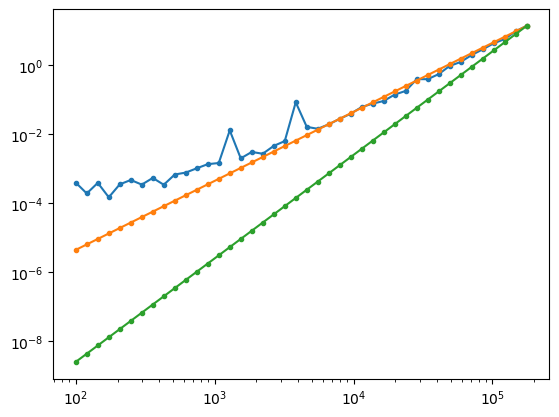

211647.10578754818 24.39761209487915
3.2368696717068075


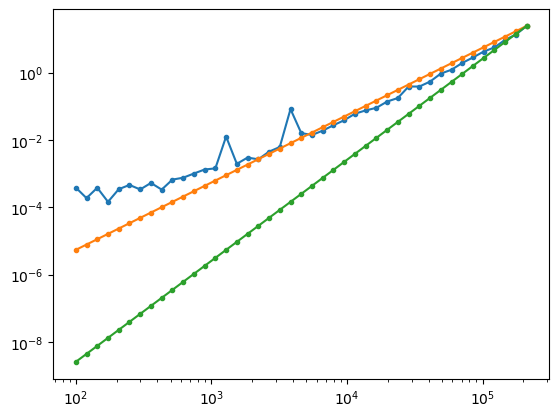

253976.5269450578 37.787038803100586
2.3995017383883908


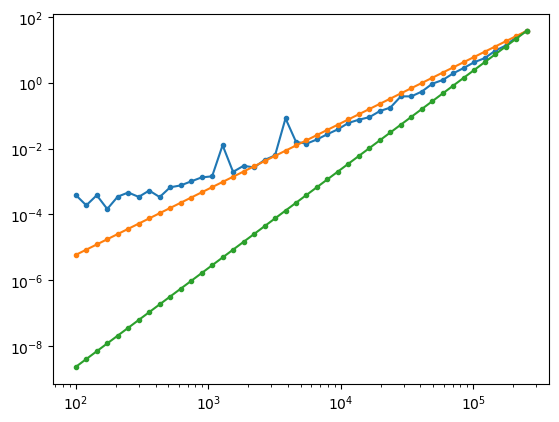

KeyboardInterrupt: 

In [16]:
max_prods = []
times = []
max_prod = 100
rat = 1.2
while True:
    _, t = time_fn(find_prime_dice, nom=7, den=16, max_prod=int(max_prod), v=False)
    max_prods.append(max_prod)
    times.append(t)
    print(max_prod, t, flush=True)
    if t > 1:
        print(log(t/times[-2])/log(rat))
    if t > 10:
        plt.loglog(max_prods, times, '.-')
        plt.loglog(max_prods, (np.array(max_prods)/max_prod)**2 * t, '.-')
        plt.loglog(max_prods, (np.array(max_prods)/max_prod)**3 * t, '.-')
        plt.show()
    max_prod *= rat

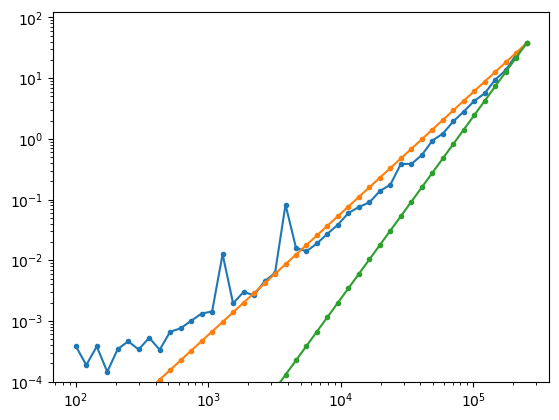

In [18]:
max_prod = max_prods[-1]
plt.loglog(max_prods, times, '.-')
plt.loglog(max_prods, (np.array(max_prods)/max_prod)**2 * t, '.-')
plt.loglog(max_prods, (np.array(max_prods)/max_prod)**3 * t, '.-')
plt.ylim(1e-4, None)
plt.show()

In [ ]:
for i in range(10):
    _, t = time_fn(find_prime_dice, nom=7, den=16, max_prod=10**i, v=False)
    print(f'10**{i}', t)

10**0 1.2874603271484375e-05
10**1 8.344650268554688e-06
10**2 5.9604644775390625e-05
10**3 0.0007483959197998047
10**4 0.17228293418884277
10**5 10.589860200881958


In [25]:
DICE = [4, 6, 8, 10, 12, 20]

In [38]:
DICE = [4, 6, 8, 12, 20, 30, 48, 60, 120] + [10] # 24

In [ ]:
max_dice = 11
max_den = 50
good_primes = list(set(sum([prime_factors(n) for n in DICE], ())))
bad_primes = [p for p in primes_below(max_den) if p not in good_primes]

for den in range(1, max_den):
    if not any(den%k == 0 for k in bad_primes):
        print(den)
        for nom in range(den//2 + 1):
            if gcd(nom, den) > 1:
                continue
            find_dice(nom, den, max_dice)

1
2
3
4
5
6
8
9
1/9 3 (10, 30, 6) 37
2/9 4 (6, 6, 6, 4) 16
2/9 4 (10, 8, 6, 6) 21
2/9 4 (10, 20, 12, 12) 36
4/9 8 (10, 60, 60, 60, 8, 8, 8, 6) 119
10
12
15
16
18
1/18 2 (30, 6) 33
5/18 2 (6, 6) 9
7/18 3 (8, 6, 6) 13
20
24
25
1/25 2 (30, 30) 53
2/25 4 (10, 10, 10, 6) 28
3/25 2 (10, 30) 33
4/25 6 (120, 120, 30, 30, 20, 6) 220
4/25 6 (10, 30, 30, 8, 4, 4) 60
4/25 6 (10, 120, 120, 20, 8, 8) 199
4/25 6 (10, 10, 10, 60, 60, 8) 109
6/25 6 (10, 30, 30, 4, 4, 4) 54
7/25 2 (10, 10) 14
8/25 4 (10, 10, 10, 4) 22
9/25 2 (10, 10) 13
11/25 5 (10, 10, 10, 10, 10) 29
12/25 3 (48, 30, 30) 57
27
1/27 3 (30, 30, 6) 57
2/27 4 (30, 8, 6, 6) 41
2/27 4 (10, 12, 6, 6) 27
2/27 4 (10, 60, 12, 12) 76
4/27 4 (10, 30, 12, 12) 46
5/27 4 (12, 8, 6, 6) 23
7/27 3 (6, 6, 6) 13
7/27 3 (12, 6, 6) 17
8/27 7 (60, 60, 8, 8, 6, 6, 4) 94
10/27 11 (60, 30, 30, 12, 6, 6, 6, 6, 6, 4, 4) 99
10/27 11 (120, 60, 60, 20, 20, 20, 8, 6, 6, 6, 4) 187
10/27 11 (10, 60, 30, 30, 8, 8, 8, 4, 4, 4, 4) 99
10/27 11 (10, 120, 60, 60, 30, 12, 8, 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73205ef09fa0>>
Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73205ef09fa0>>
Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73205ef09fa0>>
Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_fra

In [35]:
max_dice = 11
max_den = 50
good_primes = list(set(sum([prime_factors(n) for n in DICE], ())))
bad_primes = [p for p in primes_below(max_den) if p not in good_primes]

for den in range(1, max_den):
    if not any(den%k == 0 for k in bad_primes):
        print(den)
        for nom in range(den//2 + 1):
            if gcd(nom, den) > 1:
                continue
            find_dice(nom, den, max_dice)

1
2
3
4
5
6
8
9
1/9 4 (20, 8, 6, 6) 31
1/9 4 (48, 30, 30, 8) 84
2/9 4 (6, 6, 6, 4) 16
4/9 11 (120, 120, 120, 20, 20, 12, 12, 8, 8, 6, 6) 241
4/9 11 (120, 120, 120, 24, 12, 12, 12, 12, 8, 6, 6) 241
4/9 11 (120, 120, 120, 24, 20, 12, 8, 6, 6, 4, 4) 237
4/9 11 (120, 120, 120, 24, 24, 6, 6, 4, 4, 4, 4) 233
4/9 11 (120, 120, 120, 30, 12, 8, 6, 6, 6, 6, 6) 235
4/9 11 (120, 120, 120, 30, 12, 12, 6, 4, 4, 4, 4) 233
10
12
15
16
18
1/18 2 (30, 6) 33
5/18 2 (6, 6) 9
7/18 3 (8, 6, 6) 13
20
24
25
1/25 2 (30, 30) 53
2/25 7 (60, 60, 20, 8, 6, 6, 6) 124
3/25 7 (30, 30, 12, 6, 6, 4, 4) 66
3/25 7 (120, 120, 24, 20, 8, 6, 6) 218
3/25 7 (120, 120, 30, 12, 6, 4, 4) 214
4/25 6 (120, 120, 30, 30, 20, 6) 220
6/25 10 (120, 120, 20, 20, 20, 4, 4, 4, 4, 4) 203
6/25 10 (120, 120, 24, 20, 12, 6, 6, 6, 6, 4) 205
7/25 10 (120, 120, 12, 12, 12, 8, 8, 8, 4, 4) 190
7/25 10 (120, 120, 20, 8, 8, 8, 4, 4, 4, 4) 186
8/25 not found in 11 !!!!!!!!!!


KeyboardInterrupt: 

In [19]:
7511 * 21 * 2

315462

In [24]:
max_den = 1000
max_prod = 1_000_000

for den in range(1, max_den):
    print()
    print(den, prime_factors(den), flush=True)
    for nom in range(den//2 + 1):
        if gcd(nom, den) > 1:
            continue
        find_prime_dice(nom, den, max_prod)


1 ()

2 (2,)

3 (3,)

4 (2, 2)

5 (5,)

6 (2, 3)

7 (7,)

8 (2, 2, 2)
3/8 18 (2, 3, 3) 11

9 (3, 3)
2/9 2 (2,) 7
4/9 >1000...
4/9 >2000...
4/9 2625 (3, 5, 5, 5, 7) 20

10 (2, 5)

11 (11,)

12 (2, 2, 3)
5/12 25 (5, 5) 12

13 (13,)

14 (2, 7)

15 (3, 5)
2/15 2 (2,) 9
4/15 15 (3, 5) 12
7/15 845 (5, 13, 13) 23

16 (2, 2, 2, 2)
3/16 2 (2,) 9
7/16 >1000...
7/16 >2000...
7/16 >3000...
7/16 >4000...
7/16 >5000...
7/16 >6000...
7/16 >7000...
7/16 >8000...
7/16 >9000...
7/16 >10000...
7/16 >11000...
7/16 >12000...
7/16 >13000...
7/16 >14000...
7/16 >15000...
7/16 >16000...
7/16 >17000...
7/16 >18000...
7/16 >19000...
7/16 >20000...
7/16 >21000...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73205ef09fa0>>
Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
max_den = 1000
max_prod = 1_000_000

for den in range(1, max_den):
    print()
    print(den, prime_factors(den), flush=True)
    for nom in range(den//2 + 1):
        if gcd(nom, den) > 1:
            continue
        find_prime_dice(nom, den, max_prod)


1 ()

2 (2,)

3 (3,)

4 (2, 2)

5 (5,)

6 (2, 3)

7 (7,)

8 (2, 2, 2)
3/8 18 (2, 3, 3) 11

9 (3, 3)
2/9 2 (2,) 7
4/9 >1000...
4/9 >2000...
4/9 2625 (3, 5, 5, 5, 7) 20

10 (2, 5)

11 (11,)

12 (2, 2, 3)
5/12 25 (5, 5) 12

13 (13,)

14 (2, 7)

15 (3, 5)
2/15 2 (2,) 9
4/15 15 (3, 5) 12
7/15 845 (5, 13, 13) 23

16 (2, 2, 2, 2)
3/16 2 (2,) 9
7/16 >1000...
7/16 >2000...
7/16 >3000...
7/16 >4000...
7/16 >5000...
7/16 >6000...
7/16 >7000...
7/16 >8000...
7/16 >9000...
7/16 >10000...
7/16 >11000...
7/16 >12000...
7/16 >13000...
7/16 >14000...
7/16 >15000...
7/16 >16000...
7/16 >17000...
7/16 >18000...
7/16 >19000...
7/16 >20000...
7/16 >21000...
7/16 >22000...
7/16 >23000...
7/16 >24000...
7/16 >25000...
7/16 >26000...


In [ ]:
max_den = 100
max_prod = 7511 * 21 * 2

for den in range(1, max_den):
    print()
    print(den, prime_factors(den), flush=True)
    for nom in range(den//2 + 1):
        if gcd(nom, den) > 1:
            continue
        find_prime_dice(nom, den, max_prod)


1 ()

2 (2,)

3 (3,)

4 (2, 2)

5 (5,)

6 (2, 3)

7 (7,)

8 (2, 2, 2)
3/8 18 (2, 3, 3) 11

9 (3, 3)
2/9 2 (2,) 7
4/9 2625 (3, 5, 5, 5, 7) 20

10 (2, 5)

11 (11,)

12 (2, 2, 3)
5/12 25 (5, 5) 12

13 (13,)

14 (2, 7)

15 (3, 5)
2/15 2 (2,) 9
4/15 15 (3, 5) 12
7/15 845 (5, 13, 13) 23

16 (2, 2, 2, 2)
3/16 2 (2,) 9
7/16 not found in 19716 !!!!!!!!!!

17 (17,)

18 (2, 3, 3)
5/18 12 (2, 2, 3) 12
7/18 24 (2, 2, 2, 3) 13

19 (19,)

20 (2, 2, 5)
3/20 6 (2, 3) 12
7/20 6665 (5, 31, 43) 54
9/20 not found in 15773 !!!!!!!!!!

21 (3, 7)
2/21 2 (2,) 11
4/21 15 (3, 5) 14
5/21 10 (2, 5) 13
8/21 7511 (7, 29, 37) 49
10/21 361 (19, 19) 27

22 (2, 11)

23 (23,)

24 (2, 2, 2, 3)
7/24 627 (3, 11, 19) 29
